# 1. What is GWAS?

## 1.1 Genetic variation

### 1.1.2 Genotypes and Hardy-Weinberg equilibrium

##### Example 1.1

In [1]:
geno = c(66, 29, 4)
n = sum(geno)
f = sum(geno * c(0, 1, 2)) / (2*n)
f

[1] 0.1868687

In [2]:
hwe.prop = c((1-f)^2, 2*f*(1-f), f^2)
rbind(obs = geno/n, hwe = hwe.prop)

obs,0.6666667,0.2929293,0.04040404
hwe,0.6611825,0.3038976,0.03491991


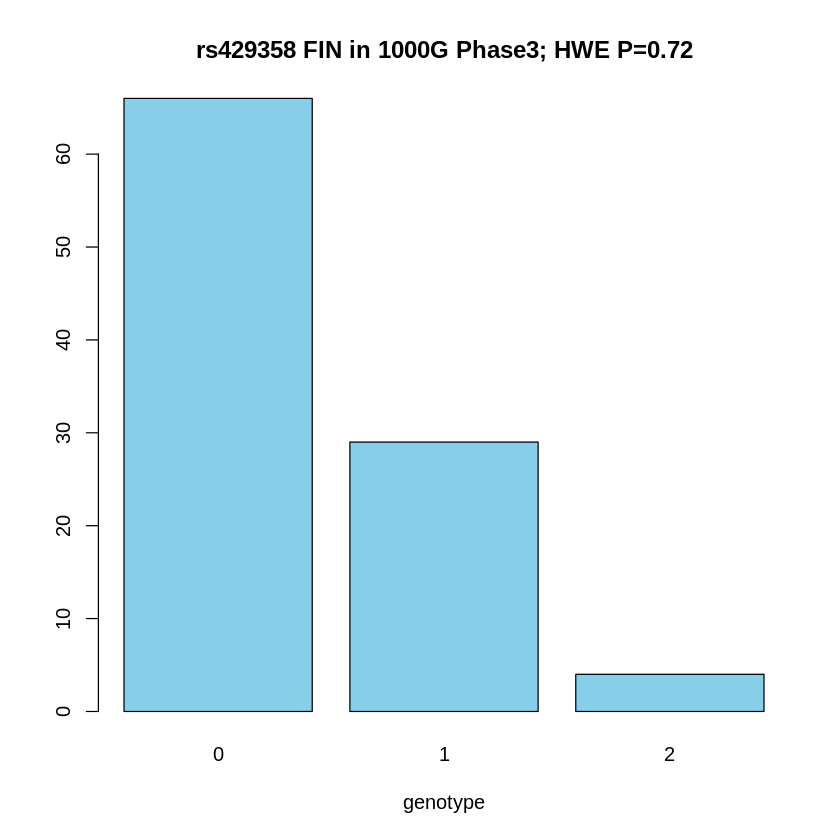

In [3]:
hwe.test = sum((geno - n*hwe.prop)^2 / (n*hwe.prop))
hwe.p = pchisq(hwe.test, df=1, lower=FALSE)

barplot(geno, main=paste0("rs429358 FIN in 1000G Phase3; HWE P=", signif(hwe.p, 3)),
        names = c(0, 1, 2), xlab = "genotype", col="skyblue")

##### Synthetic data

In [4]:
set.seed(19)
n = 1000
sample.from.geno = sample(c(0, 1, 2), prob=geno, size=n, replace=T)
tab = table(sample.from.geno)
counts.from.geno = rep(0, 3)
counts.from.geno[1 + as.numeric(names(tab))] = as.numeric(tab)

sample.from.hwe = rbinom(n, size=2, p=f)
counts.from.hwe = rep(0, 3)
for(ii in 0:2) {
    counts.from.hwe[ii+1] = sum(sample.from.hwe == ii)
}

rbind(geno = counts.from.geno/n, hwe = counts.from.hwe/n)

geno,0.651,0.313,0.036
hwe,0.672,0.298,0.030


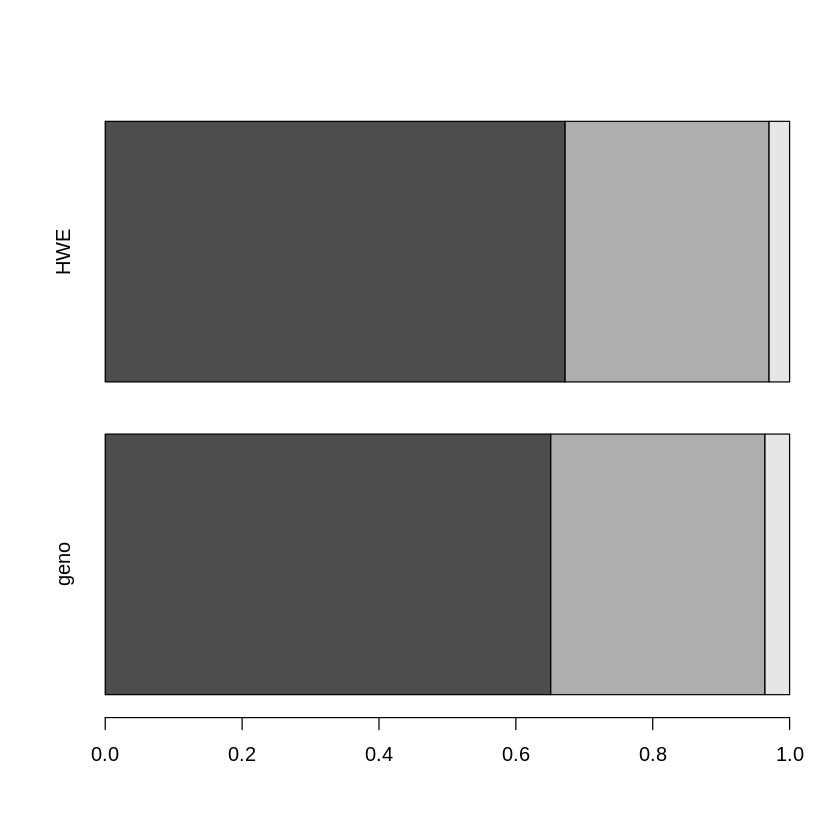

In [5]:
barplot(cbind(counts.from.geno/n, hwe=counts.from.hwe/n),
       names=c("geno", "HWE"), beside=F, horiz=T)

In [6]:
interval.from.geno = matrix(NA, ncol=2, nrow=3)
interval.from.hwe = matrix(NA, ncol=2, nrow=3)
for(ii in 1:3) {
    interval.from.geno[ii,] = qbeta(c(0.025, 0.975), counts.from.geno[ii]+0.5, n-counts.from.geno[ii]+0.5)
    interval.from.hwe[ii,] = qbeta(c(0.025, 0.975), counts.from.hwe[ii]+0.5, n-counts.from.hwe[ii]+0.5)
}

In [7]:
cbind(geno.est = counts.from.geno/n, interval.from.geno,
     hwe.est=counts.from.hwe/n, interval.from.hwe)

geno.est,,,hwe.est,,
0.651,0.62105469,0.68007266,0.672,0.64243720,0.70056879
0.313,0.28483127,0.34224942,0.298,0.27026622,0.32690115
0.036,0.02576052,0.04891794,0.030,0.02074395,0.04196844


In [8]:
chisq_result <- chisq.test(rbind(counts.from.geno, counts.from.hwe))
chisq_result


	Pearson's Chi-squared test

data:  rbind(counts.from.geno, counts.from.hwe)
X-squared = 1.247, df = 2, p-value = 0.5361


## 1.2 What is a genome-wide association study?

### 1.2.1 Quantitative traits

In [9]:
n = 10000
f = 0.04
mu = c(0.02, -0.40, -2.00) # mean of each genotype
sigma = c(1, 1, 1) # SD for each genotype

x = rbinom(n, size=2, p=f)
table(x) / n

x
     0      1      2 
0.9212 0.0772 0.0016 

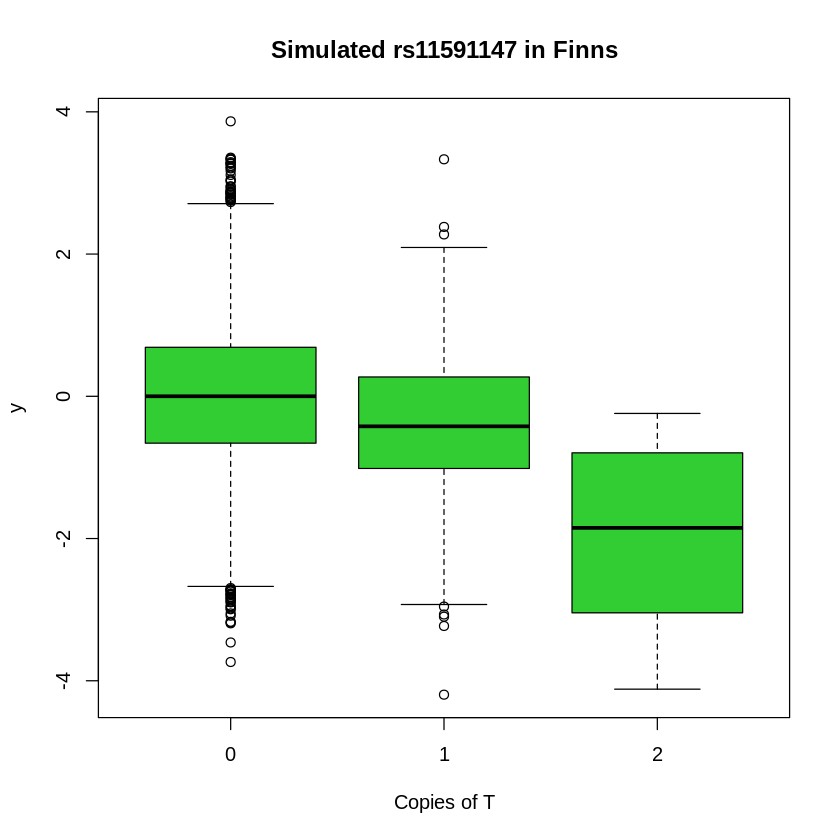

In [10]:
y = rep(NA, n)
for(ii in 0:2) {
    y[x==ii] = rnorm(sum(x==ii), mu[1+ii], sigma[1+ii])
}

boxplot(y ~ x, main="Simulated rs11591147 in Finns", ylabel="LDL",
        xlab="Copies of T", col="limegreen")

##### Additive model

In [11]:
lm.fit = lm(y ~ x)
summary(lm.fit)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7634 -0.6652 -0.0119  0.6759  3.8529 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01358    0.01032   1.316    0.188    
x           -0.44553    0.03570 -12.480   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9915 on 9998 degrees of freedom
Multiple R-squared:  0.01534,	Adjusted R-squared:  0.01524 
F-statistic: 155.7 on 1 and 9998 DF,  p-value: < 2.2e-16


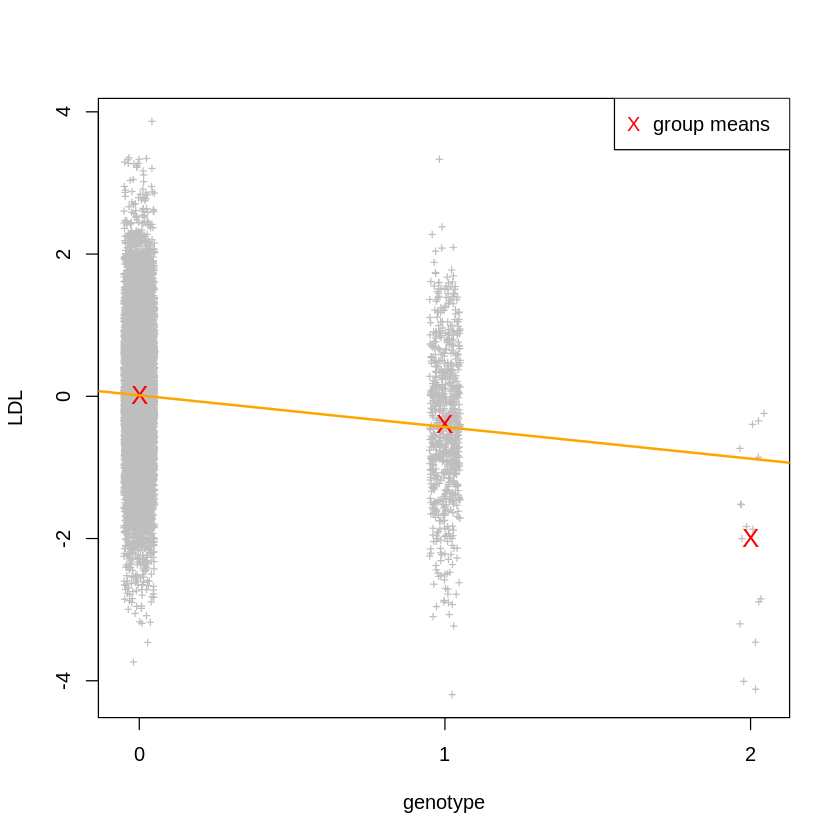

In [12]:
plot(x + runif(n, -0.05, 0.05), y, xlab="genotype", ylab="LDL", xaxt="n",
     pch=3, cex=0.50, col="gray")
axis(1, at = 0:2, labels=0:2)
points(0:2, c(mean(y[x==0]), mean(y[x==1]), mean(y[x==2])), col="red", pch="X", cex=1.3)
abline(lm.fit, col="orange", lwd=2)
legend("topright", pch="X", legend="group means", col="red")

In [13]:
z = as.numeric(x == 2)
lm.full = lm(y ~ x + z)
summary(lm.full)


Call:
lm(formula = y ~ x + z)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8095 -0.6675 -0.0128  0.6760  3.8548 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01165    0.01032   1.129    0.259    
x           -0.39750    0.03711 -10.711  < 2e-16 ***
z           -1.20614    0.25789  -4.677 2.95e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9905 on 9997 degrees of freedom
Multiple R-squared:  0.01749,	Adjusted R-squared:  0.01729 
F-statistic: 88.97 on 2 and 9997 DF,  p-value: < 2.2e-16


In [14]:
lm.full2 = lm(y ~ as.factor(x))
summary(lm.full2)


Call:
lm(formula = y ~ as.factor(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8095 -0.6675 -0.0128  0.6760  3.8548 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.01165    0.01032   1.129    0.259    
as.factor(x)1 -0.39750    0.03711 -10.711  < 2e-16 ***
as.factor(x)2 -2.00115    0.24784  -8.074 7.56e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9905 on 9997 degrees of freedom
Multiple R-squared:  0.01749,	Adjusted R-squared:  0.01729 
F-statistic: 88.97 on 2 and 9997 DF,  p-value: < 2.2e-16


##### Quantile normalization

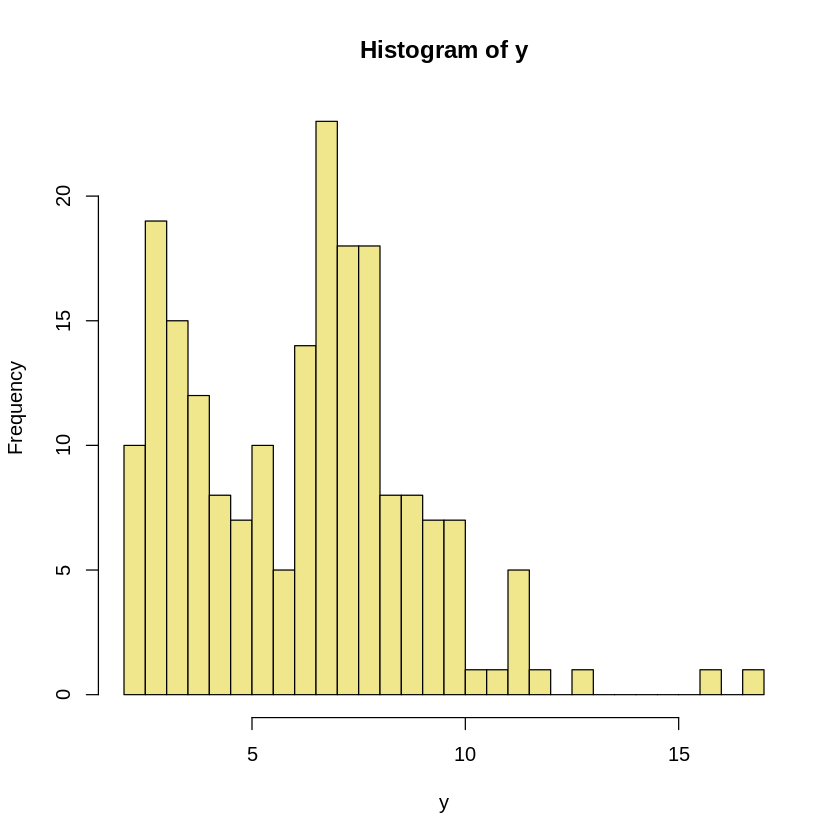

In [15]:
n = 200 # males + females
fem = rep(c(0, 1), each=n/2) # who is female
y = 2 + rgamma(n, shape=1.5, scale=1.5) # males have shift of 2
y[fem==1] = 4 + y[fem==1] # females have shift of 6 = 2 + 4
hist(y, breaks=30, col="khaki") # shows some outliesr compared to mixture of 2 Normals

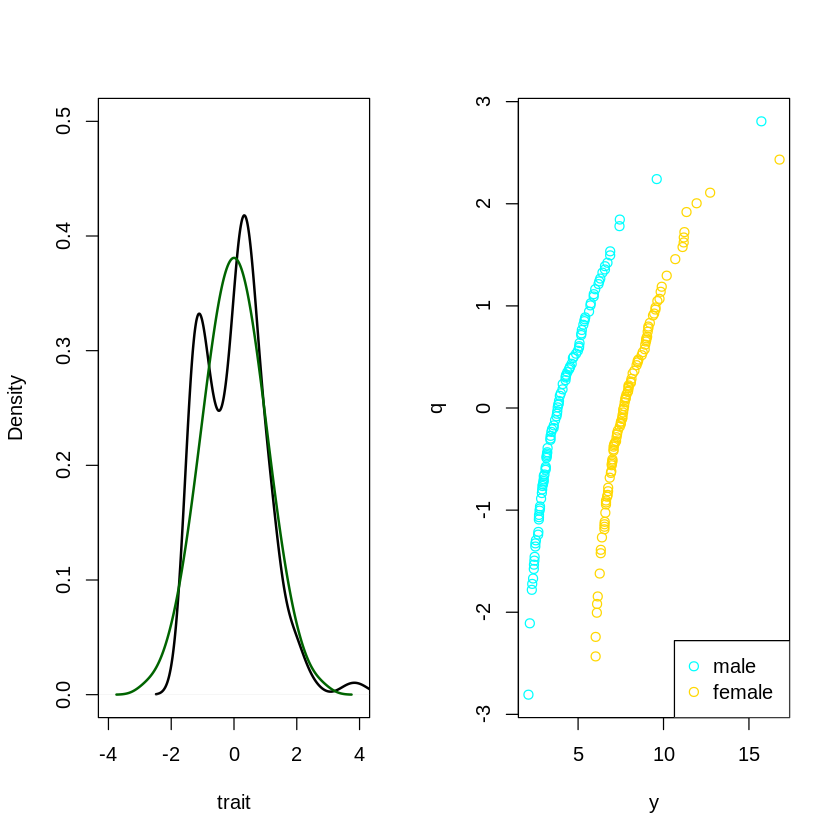

In [16]:
# regress out sex and take residuals
lm.fit = lm(y ~ fem)
r = residuals(lm.fit)

# find QN'ed trait values from qnorm = inverse of cumulative distribution of Normal
inv.normalise <- function(x) { # this would also tolerate NAs
    return(qnorm((rank(x, na.last="keep") - 0.50) / sum(!is.na(x))))
}
q = inv.normalise(r)

# Lets plot y and q (after scaling to mean=0, var=1)
par(mfrow=c(1, 2))
plot(density(scale(y)), col="black", lwd=2, xlim=c(-4, 4), ylim=c(0, 0.5), 
     xlab="trait", main="")
lines(density(scale(q)), col="darkgreen", lwd=2)
plot(y, q, col=c("cyan", "gold")[1+fem])
legend("bottomright", col=c("cyan", "gold"), pch=1, leg=c("male", "female"))

### 1.2.2 Binary phenotypes

##### Example 1.5

In [17]:
or = 1.43
a.cntrl = 0.13
q = c((1-a.cntrl)^2, 2*a.cntrl*(1-a.cntrl), a.cntrl^2) # HWE hold in controls
f.0 = 1 / (1 + or * q[2]/q[1] + or^2 * q[3]/q[1])
f = c(f.0, or * q[2]/q[1] * f.0, or^2 * q[3]/q[1] * f.0)
rbind(controls=q, cases=f) # printout cases and controls

controls,0.7569000,0.2262000,0.01690000
cases,0.6788799,0.2901236,0.03099654


In [18]:
n = 2000
x.cases = sample(c(0, 1, 2), prob=f, size=n, replace=T)
x.controls = sample(c(0, 1, 2), prob=q, size=n, replace=T)
x = c(x.cases, x.controls) # genotype of all samples
y = c(rep(1, n), rep(0, n)) # binary phenotype corresponding to genotypes
glm.fit = glm(y ~ x, family="binomial")
summary(glm.fit)


Call:
glm(formula = y ~ x, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4894  -1.1252  -0.1153   1.2305   1.2305  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.12409    0.03685  -3.368 0.000758 ***
x            0.41655    0.06360   6.550 5.75e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5545.2  on 3999  degrees of freedom
Residual deviance: 5501.3  on 3998  degrees of freedom
AIC: 5505.3

Number of Fisher Scoring iterations: 4


In [19]:
b = summary(glm.fit)$coeff[2, 1] # estimate, beta-hat
se = summary(glm.fit)$coeff[2, 2] # standard error
exp(c(b, b - 1.96*se, b + 1.96*se)) # endpoints always on logOR scale, then transform to OR scale

[1] 1.516720 1.338973 1.718063

In [20]:
s1 = sum(x.cases == 1); s0 = sum(x.cases == 0); r1 = sum(x.controls == 1); r0 = sum(x.controls == 0)
or.1.counts = (s1/r1) / (s0/r0)
se.1.counts = sqrt(sum(1 / c(s1, s0, r1, r0)))
c(or.1.counts, exp(log(or.1.counts) - 1.96*se.1.counts), exp(log(or.1.counts) + 1.96*se.1.counts))

[1] 1.580529 1.367507 1.826735

In [21]:
glm.fit = glm(y[x!=2] ~ x[x!=2], family="binomial")
b = summary(glm.fit)$coeff[2, 1] # estimate, beta-hat
se = summary(glm.fit)$coeff[2, 2] # standard error
exp(c(b, b - 1.96*se, b + 1.96*se))

[1] 1.580529 1.367512 1.826729

In [22]:
z = as.numeric(x==2)
glm.full = glm(y ~ x + z, family="binomial")
summary(glm.full)


Call:
glm(formula = y ~ x + z, family = "binomial")

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.40059  -1.12268  -0.07657   1.23314   1.23314  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.13011    0.03726  -3.492 0.000479 ***
x            0.45776    0.07386   6.197 5.74e-10 ***
z           -0.27459    0.24920  -1.102 0.270526    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5545.2  on 3999  degrees of freedom
Residual deviance: 5500.1  on 3997  degrees of freedom
AIC: 5506.1

Number of Fisher Scoring iterations: 4
